# Estimating genome-wide haplotype frequencies using LightGBM 

### Overall workflow:

1) Generate simulated populations with recombination/drift with simulate_population. Takes as input a matrix of genotypes at fixed intervals for population founders (each column is a population).
2) Calculate true haplotype frequencies in simulated populations for model training with get_true_freqs
3) Generate simulated NGS data from populations with generate_reads
4) Map reads, call SNPs in populations and founder lines
5) Define genomic windows and identify true haplotype frequency per window with either define_windows or define_by_SNPs
6) Train model using observed SNP frequencies and true haplotype frequencies per window 
7) Evaluate model performance, visualize predicted/true frequencies


In [ ]:
#have to run python 3.10 for now, biopython does not yet support 3.13

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pysam
from Bio import SeqIO
import random
from itertools import combinations
import matplotlib.pyplot as plt
import lightgbm as lgb


In [ ]:
data = pd.read_csv('/Users/tyler/Desktop/haplotype_ML/chr3L_RILs_updated.csv')
df = pd.DataFrame(data)


In [ ]:
df.head()

In [ ]:
#set RILs to df columns
df_wide = df.pivot_table(index=['CHROM', 'pos'], columns='sample', values='fHap', aggfunc='first')

In [ ]:
df_wide.head()

In [ ]:
# recombination function to be used in simulate_population
def recombine(chrom1, chrom2):
    
    # randomly select a recombination point (window) between the chromosomes at 10,000bp interval
    recombination_point = random.randrange(0, len(chrom1) - 1)  # Choose a point for crossover
    
    # create the offspring chromosome with recombination
    new_chrom1 = pd.concat([chrom1.iloc[:recombination_point], chrom2.iloc[recombination_point:]])
    new_chrom2 = pd.concat([chrom2.iloc[:recombination_point], chrom1.iloc[recombination_point:]])
    
    return new_chrom1, new_chrom2

In [ ]:
# function to simulate population w/drift
def simulate_population(RIL_matrix, n_flies, n_generations, recombination_rate):
    # initiate starting population
    population = RIL_matrix.sample(n=n_flies*2, axis=1, replace=True)
    
    for generation in range(n_generations):
        
        # create an empty dataFrame for next generation
        new_population = pd.DataFrame(index = population.index, columns = population.columns)
        
        # simulate mating and recombination
        i = 0
        while i < len(new_population.columns):

            parent1 = population.iloc[:, random.randint(1, len(population.columns) - 1)]
            parent2 = population.iloc[:, random.randint(1, len(population.columns) - 1)] 
            
            if random.random() < recombination_rate:
           
                offspring1, offspring2 = recombine(parent1, parent2)
              
            else:
                # no recombination, copy parents
                offspring1 = parent1.copy()
                offspring2 = parent2.copy()
            
            # add offspring chromosomes to new generation
            new_population.iloc[:, i] = offspring1
            if i + 1 < n_flies:
                new_population.iloc[:, i + 1] = offspring2

            i += 1

        # drift
        population = new_population.sample(n=n_flies*2, axis=1, replace=True)
    
    return population



In [ ]:
#determines true haplotype frequency in simulated population
def get_true_freqs(simulated_pop):

    haplotype_columns = simulated_pop.columns.difference(['sample', 'CHROM', 'pos'])
    haplotype_counts = simulated_pop[haplotype_columns].apply(lambda x: x.value_counts(), axis=1).fillna(0)
    haplotype_frequencies = haplotype_counts.div(haplotype_counts.sum(axis=1), axis=0)

    return haplotype_frequencies 

In [ ]:
#coordinates to simulated PE reads, adjust average read length as desired
def read_coordinates(population, chroms):

    #get read length from normal distribution
    read_length_f = np.round((np.random.normal(loc = 150, scale = 10))).astype(int)
    read_length_r = np.round((np.random.normal(loc = 150, scale = 10))).astype(int)

    #library fragment length and inner distance
    fragment = np.round((np.random.normal(loc = 500, scale = 50))).astype(int)
    gap = fragment - (read_length_f + read_length_r)

    #select chromosome to read
    chromosome = np.random.choice(chroms, replace = True) 
    
     #subset population data to get max position of chromosome
    chrom_of_interest = population.loc[chromosome]
    max_pos = chrom_of_interest.index.max()

    #define read boundaries
    read_start_f = np.random.randint(1, max_pos - 2000) 
    read_end_f = read_start_f + read_length_f

    read_end_r = read_end_f + gap
    read_start_r = read_end_r + read_length_r


    return chromosome, read_start_f, read_end_f, read_length_f, read_start_r, read_end_r, read_length_r


In [ ]:
#generate reverse complement for PE2
def reverse_complement(seq):

    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

    return ''.join(complement.get(base, base) for base in seq)

In [ ]:
#should be one fasta file per chromosome, each containing  all the full set of template sequences (i.e. founder chromosomes)
def read_fasta(file_path):
    
    sequences = {}

    for record in SeqIO.parse(file_path, "fasta"):
        
        #save fastas in dict
        haplotype_id = record.id
        sequences[haplotype_id] = record.seq
        
    return sequences

In [ ]:
#outputs PE reads
def generate_reads(population, chromosome_list, read_num, out_name):

    #store number of reads generated per haplotype per position (read depth) 
    haplotype_counts = pd.DataFrame(0, index=population.index, columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'])

    read_count = 0

    #initialize empty fastq file
    with open(f'{out_name}_1.fastq', 'w') as fastq_file1, open(f'{out_name}_2.fastq', 'w') as fastq_file2:

        while read_count < read_num:

            #randomly define read coordaintes
            chrom, start_f, end_f, length_f, start_r, end_r, length_r = read_coordinates(population, chromosome_list)

            #subset population dataframe to chromosome where read is
            chrom_of_interest = population.loc[chrom]

            #pick random chromosome to sequence
            template = chrom_of_interest.iloc[:, random.randint(1, len(chrom_of_interest.columns) - 1)]

            #get haplotype at position nearest to read location
            nearest_pos = min(template.index, key=lambda x: abs(x - start_f))
            haplotype = template[nearest_pos]

            #generate read
            fasta_seqs = chromosome_dict[chrom]
            haplotype_sequence = fasta_seqs[haplotype] 
            
            forward_read = haplotype_sequence[start_f:end_f]
            reverse_read = haplotype_sequence[end_r:start_r] # end_r is start of read before flipping it
            reverse_read = reverse_complement(reverse_read)
            reverse_read = reverse_read[::-1]  # flip reverse the sequence
            

            #track reads per haplotype
            haplotype_counts.at[(chrom, nearest_pos), haplotype] += 1
            read_count += 1
            read_ID = random.randint(1000, 9999) 

            #write read to fastq file:
            read_quality_f = 'I'*len(forward_read)
            fastq_file1.write(f'@{chrom}_{start_f}_{read_ID}/1\n')
            fastq_file1.write(f'{forward_read}\n')
            fastq_file1.write("+\n")
            fastq_file1.write(f'{read_quality_f}\n')

            read_quality_r = 'I'*len(reverse_read) 
            fastq_file2.write(f'@{chrom}_{start_f}_{read_ID}/2\n')  
            fastq_file2.write(f'{reverse_read}\n')
            fastq_file2.write("+\n")
            fastq_file2.write(f'{read_quality_r}\n')
          

    return haplotype_counts, fastq_file1, fastq_file2

In [ ]:
#alternative to generate_reads, populates a sam file directly and skips mapping. cannot hand indels (will throw off index during SNP calling)

def generate_sam(population, chromosome_list, read_num, out_name):

    #store number of reads generated per haplotype per position (read depth) 
    haplotype_counts = pd.DataFrame(0, index=population.index, columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'])

    # to convert chromosome name to contig name
    contigs_chr = {
    
    'chrX' : 'NC_004354.4',
    'chr2L' : 'NT_033779.5',
    'chr2R' : 'NT_033778.4',
    'chr3L' : 'NT_037436.4' ,
    'chr3R' : 'NT_033777.3'

    }

    #create SAM file header with dmel chroms 
    sam_header_dict = {
    'HD': {'VN': '1.0', 'SO': 'unsorted'},  
    'SQ': [
        {'SN': 'NT_033779.5', 'LN': 23513712},
        {'SN': 'NT_033778.4', 'LN': 25286936},
        {'SN': 'NT_037436.4', 'LN': 28110227},
        {'SN': 'NT_033777.3', 'LN': 32079331},
        {'SN': 'NC_004353.4', 'LN': 1348131},
        {'SN': 'NC_024512.1', 'LN': 3667352}
    ]
    }

    #convert to actual pysam header
    sam_header = pysam.AlignmentHeader.from_dict(sam_header_dict)

    read_count = 0

    #initialize empty SAM file
    with pysam.AlignmentFile(f"{out_name}.sam", "w", header = sam_header) as sam_file:

        while read_count < read_num:

            #randomly define read coordaintes
            chrom, start_R1, end_R1, start_R2, end_R2 = read_coordinates(population, chromosome_list)

            #subset population dataframe to chromosome where read is
            chrom_of_interest = population.loc[chrom]

            #pick random chromosome to read
            template = chrom_of_interest.iloc[:, random.randint(1, len(chrom_of_interest.columns) - 1)]
            contig = contigs_chr[chrom]

            #get haplotype at position nearest to read location
            nearest_pos = min(template.index, key=lambda x: abs(x - start_R1))
            haplotype = template[nearest_pos]

            #generate read
            chromosome_seqs = chromosome_dict[chrom]
            haplotype_sequence = chromosome_seqs[haplotype] 
            read_R1 = haplotype_sequence[start_R1:end_R1]
            read_R2 = haplotype_sequence[start_R2:end_R2] 

            #track haplotype reads
            haplotype_counts.at[(chrom, nearest_pos), haplotype] += 1
            read_count += 1

            #write read to sam file:
            R1, R2 = make_record(sam_file, contig, read_R1, start_R1, read_R2, start_R2)
            sam_file.write(R1)
            sam_file.write(R2)

    return haplotype_counts, sam_file

In [ ]:
#works with generate_sam
def make_sam_record(sam, contig_name, R1_sequence, R1_start, R2_sequence, R2_start):
    
    #define mate 1
    R1 = pysam.AlignedSegment(header = sam.header)  
    R1.query_sequence = str(R1_sequence)
    R1.cigarstring = f"{len(R1_sequence)}M"
    R1.query_name = f"{contig_name}_{R1_start}_R1"  
    R1.flag = 99
    R1.reference_start = R1_start
    R1.reference_id = sam.get_tid(contig_name)
    R1_quality = "I"*len(R1_sequence)
    R1.query_qualities = pysam.qualitystring_to_array(R1_quality)
    R1.mapping_quality = 60

    #define mate 2
    R2 = pysam.AlignedSegment(header = sam.header)  
    R2.query_sequence = str(R2_sequence)
    R2.cigarstring = f"{len(R2_sequence)}M"
    R2.query_name = f"{contig_name}_{R1_start}_R2"
    R2.flag = 147
    R2.reference_start = R2_start
    R2.reference_id = sam.get_tid(contig_name) 
    R2_quality = "I"*len(R2_sequence)
    R2.query_qualities = pysam.qualitystring_to_array(R2_quality)
    R2.mapping_quality = 60 

    #mate pair info
    R1.next_reference_id = R2.reference_id
    R1.next_reference_start = R2.reference_start

    R2.next_reference_id = R1.reference_id
    R2.next_reference_start = R1.reference_start

    R2_end = R2_start + len(R2_sequence) - 1
    template_length = R2_end - R1_start + 1

    R1.template_length = template_length  # Positive TLEN for R1
    R2.template_length = -template_length
    
    return R1, R2

    

In [ ]:
#returns dictionary where key = genomic position of window start/end and values window: 9 x N matrix (N = number of snps) and 
#true_freqs (true haplotype frequencies of that window). ultimately dictionary will be converted to feature (window) and label (true_freqs) numpy arrays

def define_windows(observed_frequencies, true_frequencies, window, step, sim):
    
    results = {}
    
    for window_start in range(observed_frequencies['pos'].min(), observed_frequencies['pos'].max() - window, step):
        # define  window in observed_frequencies
        window_end = window_start + window
        window_data = observed_frequencies[(observed_frequencies['pos'] >= window_start) & (observed_frequencies['pos'] < window_end)]

        #minimum number of SNPs per window
        if window_data.shape[0] > 20:
            
            # determine window center
            middle_obs = window_data['pos'].median()
            window_data = window_data.iloc[:, 2:11]
            window_data = window_data.reset_index(drop = True)
            
            # determine true frequencies at window center
            middle_true = min(true_frequencies['pos'], key=lambda x: abs(x - middle_obs))
            window_true_freq = true_frequencies[true_frequencies['pos'] == middle_true].iloc[:, 2:10]
            window_true_freq = window_true_freq.reset_index(drop = True)

            # store the window and corresponding true_freqs row in the dictionary
            results[str(sim), (str(window_start), 
                 str(window_end))] = {'window': window_data, 'true_freq_row': window_true_freq}
            
    
    return results

In [ ]:
#same as above, but sets window size based on SNP number instead of window length
def define_by_SNPs(observed_frequencies, true_frequencies, snp_number, step, sim):
    
    results = {}
    window_start = 0
    window_end = window_start + snp_number

    while window_end < observed_frequencies.index.max():

        # define  window in observed_frequencies
        window_data = observed_frequencies.iloc[window_start:window_end, :]
     
        # determine window center
        middle_obs = window_data['pos'].median()
        window_data = window_data.iloc[:, 2:11]
        window_data = window_data.reset_index(drop = True)
            
        # determine true frequencies at window center
        middle_true = min(true_frequencies['pos'], key=lambda x: abs(x - middle_obs))
        window_true_freq = true_frequencies[true_frequencies['pos'] == middle_true].iloc[:, 2:10]
        window_true_freq = window_true_freq.reset_index(drop = True)

        # store the window and corresponding true_freqs row in the dictionary
        results[str(sim), (str(observed_frequencies.iloc[window_start]['pos']), 
                 str(observed_frequencies.iloc[window_end]['pos']))] = {'window': window_data, 'true_freq_row': window_true_freq}
        
        window_start += step
        window_end += step

    return results

In [ ]:
#store founder fastas for each chromosome 
founders_3L = read_fasta('/Users/tyler/Desktop/haplotype_ml/founder_fastas/B.3L.fasta')

#list of chromosomes to sample (including only 3L for now, will add the other pending genotyping data)
chroms = ['chr3L']

#dict so that the correct haplotype can be called from a randomly selected chromosome by read_coordinates
chromosome_dict = {
    'chr3L' : founders_3L
}


### Setting simulation parameters and generating reads:

In [ ]:
# set simulation parameters
n_flies = 300  # population size
n_generations = 15  # number of generations
recombination_rate = 0.5  # probability of recombination occurring
read_num = 500000 # when generating data for chr3L only this simulates ~100X read depth
num_sims = 100 # number of populations to create

In [ ]:
# i ran this from the cluster due to memory constraints, took ~8 hours to simulate data for 100 populations. 
# see scripts folder on github for slurm and python scripts adapted for the cluster

for i in range(1, num_sims + 1):

    sim_name = f'sim{i}'
    sim_pop = simulate_population(df_wide, n_flies, n_generations, recombination_rate)
    true_freqs = get_true_freqs(sim_pop)
    read_depth, fq1, fq2 = generate_reads(sim_pop, chroms, read_num, sim_name)
    read_depth.to_csv(f'{sim_name}_depth.csv', index = True)
    true_freqs.to_csv(f'{sim_name}_true_freqs.csv', index = True)

    

### Running simulation from cluster, then mapping reads and calling SNPs, calculating SNP frequencies. 

```
#! /bin/bash
# Job name:
#SBATCH --job-name=simul_100
#
# Account:
#SBATCH --account=fc_poison
#
# Partition:
#SBATCH --partition=savio3
#
# Wall clock limit:
#SBATCH --time=48:00:00
#
## Command(s) to run:
source activate lgbm3.1  
python -c "import pysam"
python -c "import pandas as pd" 
python -c "import numpy as np"
python -c "from Bio import SeqIO"
python simul_100.py

module load bwa
module load samtools
module load bcftools

for file in *_1.fastq; do
    name=$(echo $file | sed 's/_1.fastq//')
    file2="${name}_2.fastq"                
    bwa mem -t 20 -M dmel_r6.fna "$file" "$file2" | samtools sort -@ 20 -o "${name}.sorted.bam"  # Align and sort
    samtools index -@ 20 "${name}.sorted.bam"  
done

bcftools mpileup -I -q 0 -Q 0 --threads 20 -t NT_037436.4 -a "FORMAT/AD,FORMAT/DP" -f dmel_r6.fna -b bam_names.txt -o sim100_mpile.txt

bcftools call --threads 20 sim100_mpile.txt -mv -Ov > sim100.vcf 

bcftools query -e 'GT ="./."' -e'QUAL<60' -f'%CHROM %POS %REF %ALT [ %AD{0} %AD{1}] [%GT]\n' sim100.vcf | sed 's/NT_037436.4/chr3L/' | grep -v '\.' | perl /global/home/users/tylerdouglas/modules/tdlong/accuracy.freqtab.pl > simul_100_freqs.txt

```

In [ ]:
#set column names for observed frequencies table
col_names = ['chrom', 'pos', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']

for i in range(1, num_sims + 1):
    sim_name = f'sim{i}'
    col_names.append(sim_name)


In [ ]:
#first 10 columns are chromosome, position, and presence/absence of each SNP in the 8 founders. 
#the rest of the columns are SNP frequency in each of the 100 simulated populations
SNP_freqs = pd.read_csv('/Users/tyler/Desktop/haplotype_ML/simul_100_freqs.csv', names = col_names, header = None)

In [ ]:
#initialize dictionary to store genomic windows/true frequencies per window
input_windows = {}

In [ ]:
#define windows, find true frequencies for that window, store in input_windows
for i in range(1, num_sims + 1):

    sim_name = f'sim{i}'
    true_freqs = pd.read_csv(f'/Users/tyler/Desktop/haplotype_ml/{sim_name}_true_freqs.csv')    #read true freqs table
    obs_freqs = SNP_freqs[['chrom', 'pos', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', sim_name]].copy()    #create df of founders + current sim
    obs_freqs['pos'] = obs_freqs['pos'].round(-3)
    print("processing windows for:", sim_name) 
    windows = define_windows(obs_freqs, true_freqs, 200000, 20000, sim_name) #both window functions work on one sim population at a time
    #windows = define_by_SNPs(obs_freqs, true_freqs, 200, 20, sim_name)
    input_windows.update(windows)

In [ ]:
#number of windows
print(len(input_windows))

In [ ]:
#lgbm performed poorly with just flattening SNP window, so generating summary statistics of each window to pass to lgbm instead
#gets counts of each haplotype per window, as well as the average frequency of SNPs that that haplotype contains 
#idea would be that if a haplotype is widespread and generally contains high frequency SNPs, it itself might be represented at a high frequency

def summarise_window(df_window):
   
    feats = {}
    sim_name = df_window.columns[-1]

    #count haplotype occurence per window, mean freq of SNPs present in that haplotype
    for haplotype in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']:

        feats[f'{haplotype}_count'] = df_window[haplotype].sum()
        feats[f'{haplotype}_mean_freq_present'] = df_window.loc[df_window[haplotype] == 1, sim_name].mean()
    
    for key in feats:
        if np.isnan(feats[key]):
            feats[key] = 0.0
    
    return feats

### Model training:

In [ ]:
#generate feature/label arrays to pass to lgbm

X_data_agg = []
y_data = []

for key, value in input_windows.items():

    df_window = value['window']  
    sim_name, (start_pos, end_pos) = key
    feats = summarise_window(df_window) #get haplotype count and mean SNP freq of SNPs the haplotype contains
    feats['sim_name'] = sim_name
    feats['window_start'] = start_pos
    feats['window_end'] = end_pos

    freq_dict = value['true_freq_row'].values.flatten() #get true frequencies for the window

    #add window haplotype statistics and true haplotype frequencies to features and labels array
    y_data.append(freq_dict)
    X_data_agg.append(feats)

X_data_agg_df = pd.DataFrame(X_data_agg)  
y_data = np.array(y_data) 

In [ ]:
#separate out sim number and genomic position so that it isn't passed to the model, but retain later for visualization
pos_cols = ['sim_name', 'window_start', 'window_end']
feature_cols = [c for c in X_data_agg_df.columns if c not in pos_cols]
X_features = X_data_agg_df[feature_cols].copy()
pos_df = X_data_agg_df[pos_cols].copy()

In [ ]:
#model performs marginally better when I include interactions between haplotypes, adding them to features array
columns = [f'B{i}_count' for i in range(1, 9)]
for col1, col2 in combinations(columns, 2):
    X_features[f'interaction_{col1}_{col2}'] = X_features[col1] * X_features[col2]

X_features['mean_SNP_presence'] = X_features[[f'B{i}_mean_freq_present' for i in range(1, 9)]].mean(axis=1)

In [ ]:
#generate training and validation data
X_train, X_test, y_train, y_test, pos_train, pos_test = train_test_split(
    X_features,   
    y_data,
    pos_df,       
    test_size=0.2,
    random_state=42
)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

In [ ]:
print(X_train.head(1))

In [ ]:
#define the model, wrap in MultiOutputRegressor
lgb_reg = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=64,
    lambda_l1=0.1,
    lambda_l2=0.2,
    objective='regression',
    min_data_in_leaf=5,
    random_state=42,
    n_jobs=-1
)

multi_lgb = MultiOutputRegressor(lgb_reg)

In [ ]:
multi_lgb.fit(X_train, y_train)

In [ ]:
y_pred = multi_lgb.predict(X_test)

In [ ]:
#model is most noisy for very low haplotype frequencies, rounding all frequencies below 0.3% to zero, can experiment with what the threshold should be
threshold = 0.008
y_pred_thresholded = np.clip(y_pred, 0, None)  
y_pred_thresholded[y_pred_thresholded < threshold] = 0  

In [ ]:
# gives metrics on model performance
def evaluate_multioutput(y_true, y_predicted):
    
    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    r2 = r2_score(y_true, y_predicted, multioutput = 'uniform_average')
    
    print("Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")


In [ ]:
#check performance with and without thresholding minimum frequency
#for 200kb windows mae = 0.02 and r^2 ~ 0.92 so performance right now is decent, slightly better than lsei
evaluate_multioutput(y_test, y_pred)
print("----")
evaluate_multioutput(y_test, y_pred_thresholded)

In [ ]:
#format and save predicted frequencies for each genomic window for visualization
results_df = pos_test.copy()
haplotypes = ['B1','B2','B3','B4','B5','B6','B7','B8']

for i, hap in enumerate(haplotypes):
    
    results_df[f'pred_{hap}'] = y_pred_thresholded[:, i]
    results_df[f'true_{hap}'] = y_test[:, i]

print(results_df.head(5))
results_df.to_csv("lgb_200kb_thresholded.csv", index=False)

### Visualizing model performance  with ggplot

```
library(ggplot2)
library(dplyr)
library(tidyr)
library(cowplot)
library(scales)

df <- read.csv("lgb_200kb_thresholded.csv")

df_ae <- df %>%
  pivot_longer(
    cols = starts_with("pred_") | starts_with("true_"), 
    names_to = c(".value", "founder"),                      
    names_sep = "_"                                    
  ) 

df_ae$ae <- abs(df_ae$true - df_long$pred)

mae <- df_ae %>%
  group_by(sim_name, founder) %>%
  summarise(mae = mean(ae), r2 = 1 - (sum((true - pred)^2) / sum((true - mean(true))^2))) %>%
  mutate(annotation = sprintf("MAE: %.3f\nR²: %.3f", mae, r2))

df_plot <- df %>%
  pivot_longer(
    cols = starts_with("pred_") | starts_with("true_"), 
    names_to = c("type", "founder"),                         
    names_sep = "_",
    values_to = "freq"
  )

mae_sim <- subset(mae, sim_name == 'sim89')

ggplot(data = subset(df_plot, sim_name == 'sim89'),
       aes(x = window_start, y = freq, group = type, color = type)) +
  geom_line(alpha = 0.7) +
  facet_wrap(~founder) +
  geom_text(data = mae_sim, 
            aes(x = Inf, y = Inf, label = annotation), 
            inherit.aes = FALSE, 
            hjust = 1.1, vjust = 1.1, 
            size = 3, color = "black") +
  scale_color_manual(values = c("#000080", "#93E1D8")) +
  theme_cowplot(font_size = 12) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_x_continuous(
    breaks = pretty_breaks(n = 5),  # Adjust number of breaks as needed
    labels = function(x) paste0(x / 1e6, "Mbp")  # Convert to millions and append "Mbp"
  ) +
  labs(x = "Genomic Position (Mbp)", y = "Frequency")
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),  
    strip.text = element_text(size = 10),  
    panel.spacing = unit(1, "lines") 
  ) 
```

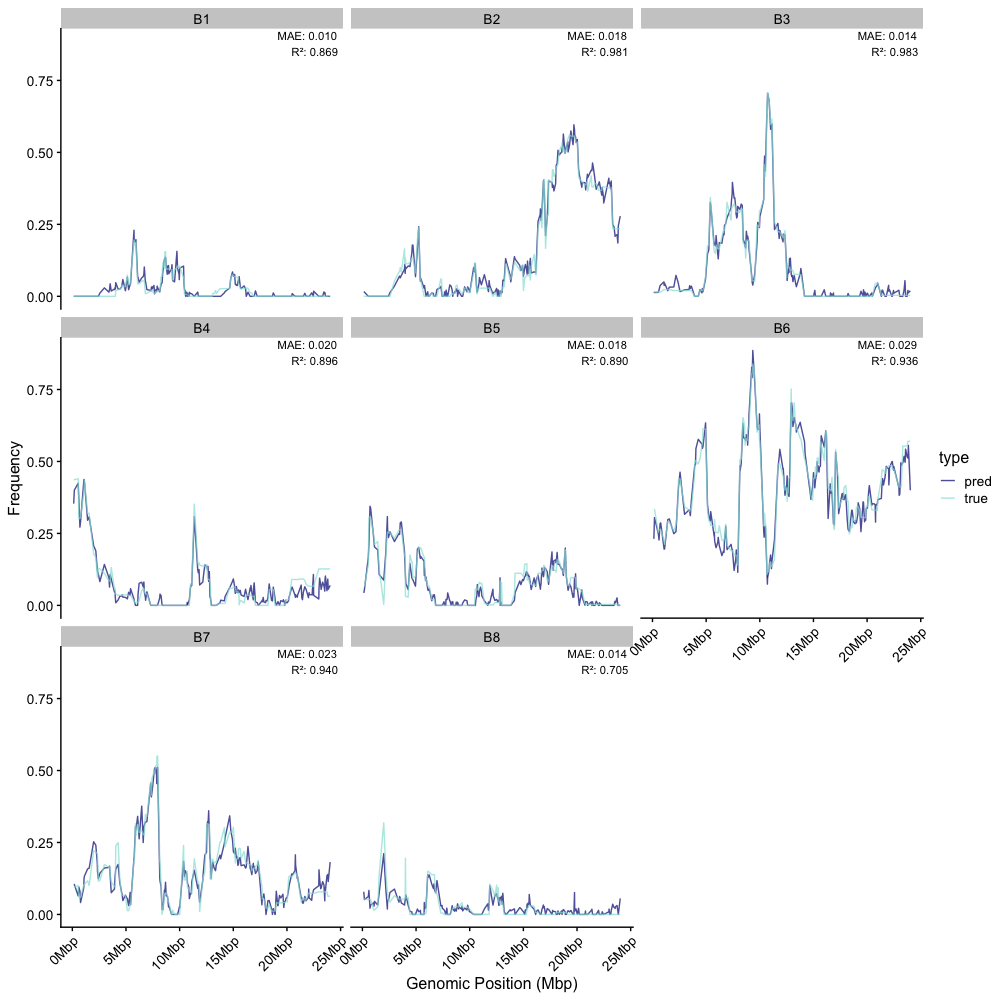

In [7]:
from IPython.display import Image, display

# Display the image
display(Image(filename='sim89.png'))